Earlier, we talked about the importance of working with time-series data with a consistent sampling rate. In other words, it's easiest to work with data when all of the data points are evenly spaced in time.

Another challenge you will run into is that you will encounter ***signal noise*** that impacts the measurements in your time-series data. In this notebook, we will cover some potential causes of signal noise and ways of addressing them.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-21 03:47:03--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   643KB/s    in 40s     

2024-06-21 03:47:43 (635 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [3]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

# What Causes Signal Noise

Sources of signal noise can be highly dependent upon the kind of data that is being collected. Below are three broad categories of signal noise:
* **Data entry:** People may manually enter information incorrectly into a survey or form, leading to outliers in your data (e.g., entering `600 bpm` instead of `60 bpm` for heart rate).
* **Intrinsic causes:** A sensor can exhibit unwanted random variation due to factors like electrical interference, thermal deviation, and electronic component limitations.
* **Extrinsic causes:** There may be disturbances outside of the sensor that get superimposed on our measurements. For instance, if we are trying to record someone's voice using a microphone, ambient background sounds can make it more difficult for us to analyze speech.

Unfortunately, there is no one-size-fits-all solution to identifying signal noise. Some cases of noise might be obvious, while others may be more subtle. There might also be situations where you think something that looks like noise is actually an important indicator of the phenomenon you are trying to measure. Making these determinations will require inspecting your data closely and reflecting on how it was collected, and picking the correct technique for addressing signal noise can be equally complex.

Below, we will cover two commonly-used techniques for dealing with sensor noise, but these are not comprehensive by any means.

# Identifying Outliers

An ***outlier*** is a data point that is significantly different from the other data points in a dataset. Identifying and removing outliers can help ensure that your analyses do not get thrown off by random perturbations that do not mean anything.

To talk about different approaches to outlier detection, let's manually create a simple time-series of resting heart rate data, which we will assume should lie between 60–100 bpm.

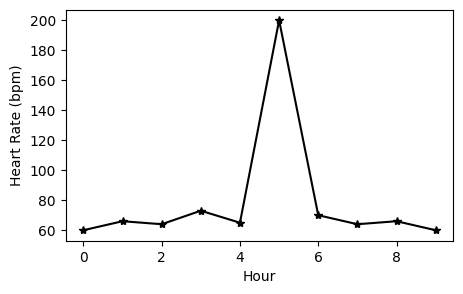

In [4]:
hr_data = [60, 66, 64, 73, 65, 200, 70, 64, 66, 60]
hr_time = list(range(len(hr_data)))
lower_bound = 60
upper_bound = 100

plt.figure(figsize=(5,3))
plt.plot(hr_time, hr_data, 'k-*')
plt.xlabel('Hour')
plt.ylabel('Heart Rate (bpm)')
plt.show()

There is a clear outlier at the 5th hour when a resting heart rate of 200 bpm was recorded. In fact, we can tell that this data point is an outlier without even knowing its timestamp, so the techniques we will cover below will primarily involve working with `hr_data` only.

## Manual Method

If you know ahead of time that your data should fall within a specific range, you can use comparators and comparator-like functions to check if your data lies within that range. Below are three examples using `if` statements, `numpy`, and `pandas`:

In [5]:
# Manual
is_outlier = []
for hr in hr_data:
    out_of_range = hr < lower_bound or hr > upper_bound
    is_outlier.append(out_of_range)
print(is_outlier)

[False, False, False, False, False, True, False, False, False, False]


In [6]:
# Numpy boolean mask
hr_array = np.array(hr_data)
(hr_array < lower_bound) | (hr_array > upper_bound)

array([False, False, False, False, False,  True, False, False, False,
       False])

In [7]:
# Pandas between
hr_series = pd.Series(hr_data)
~hr_series.between(lower_bound, upper_bound)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
dtype: bool

## Z-Score

If you don't know the range in which your data should fall ahead of time, you can manually calculate the distribution of the data and then check to see how far away each point is from that distribution.

One way of doing this is by using the ***Z-score***, which measures how many standard deviations a data point is from the mean. When you use a measure like Z-score, you will need to decide how far away a data point should be in order for it to be considered an outlier. Let's look at the Z-score for each data point in our heart rate data:

In [8]:
from scipy import stats
stats.zscore(hr_data)

array([-0.46333536, -0.31546237, -0.36475337, -0.14294389, -0.34010787,
        2.98703435, -0.21688038, -0.36475337, -0.31546237, -0.46333536])

Notice that most of our data points are within one standard deviation (i.e., their Z-score is between -1 and 1). However, our obviously incorrect data point has a Z-score that is close to 3. Therefore, we might consider that any data point with a Z-score greater than 2 or less than -2 should be considered an outlier in this case:

In [9]:
np.abs(stats.zscore(hr_data)) > 2

array([False, False, False, False, False,  True, False, False, False,
       False])

# Handling Outliers

## Placeholder Values


Handling outliers can be just as tricky as handling missing data since you don't know what the real value should have been at that timestamp.

One common approach you might have seen for handling outliers and missing data is by using a pre-determined ***placeholder value***.

Some common placeholder values you might see people use as they are saving data in Excel include `-1` (if you know that the data is always going to be positive) and `np.nan` (short for "not a number"). However, these values actually introduces new trends that make it more difficult to process your data later.

A safer placeholder value is one that you will know falls within the distribution of your data. For our heart rate data, for example, we might consider picking the average heart rate in our time series:

In [10]:
# Compute the placeholder
hr_series = pd.Series(hr_data)
placeholder = hr_series.mean()

# Find the outlier entries and replace them
outlier_mask = ~hr_series.between(lower_bound, upper_bound)
hr_series[outlier_mask] = placeholder
print(hr_series)

0    60.0
1    66.0
2    64.0
3    73.0
4    65.0
5    78.8
6    70.0
7    64.0
8    66.0
9    60.0
dtype: float64


## Interpolation

Placeholder values are applied uniformly across an entire dataset whenever there is an outlier. If your data has lots of outliers, then the same placeholder value will appear many times in your new signal. This may not be ideal since it will heavily skew the distribution of your measurements.

Rather than replacing all outliers using the same value, we can replace outliers with values that resemble nearby measurements. We can do this using the same interpolation techniques we explored earlier, bearing in mind that we should remove out outliers before generating our interpolator:

In [11]:
# Convert to numpy
hr_time_arr = np.array(hr_time)
hr_data_arr = np.array(hr_data)

# Find the clean entries
outlier_mask = (hr_array > lower_bound) & (hr_array < upper_bound)
hr_time_clean = hr_time_arr[outlier_mask]
hr_data_clean = hr_data_arr[outlier_mask]

# Interpolate in order to fill in values that are missing from the original signal
hr_resampled = np.interp(hr_time_arr, hr_time_clean, hr_data_clean)
print(hr_resampled)

[66.  66.  64.  73.  65.  67.5 70.  64.  66.  66. ]


# Summary

There are many techniques at our disposal in order to make real-world data conform to these assumptions. However, it will be important for you to consider the implications of applying these techniques to your data. If you preprocess your data too heavily, you may remove important information that will be useful down the road for other analyses.